Из строки признаков делаем словарь из признаков вида {категория: значение категории}

In [22]:
def feats_extract(features):
    features_dict = {}
    if features != '_':
        features = features.split('|')
        for feat in features:
            category = feat.split('=')[0]
            value = feat.split('=')[1]
            features_dict[category] = value
    return features_dict

Парсим conllu. Возвращает предложение и словарь из его токенов

In [23]:
def parse_sentence(sentence):
    tokens_dict = {}
    regex = r"^(.*?)\t(.*?)\t(.*?)\t(.*?)\t(.*?)\t(.*?)\t(.*?)\t(.*?)\t(.*?)\t(.*?)$"
    tokens = re.finditer(regex, sentence, re.MULTILINE)
    parsed_sentence = []
    for token in tokens:
        token_info = {}
        token_info['FORM'] = token.group(2)
        parsed_sentence.append(token_info['FORM'])
        token_info['LEMMA'] = token.group(3)
        token_info['UPOSTAG'] = token.group(4)
        token_info['XPOSTAG'] = token.group(5)
        feats = token.group(6)
        feats = feats_extract(feats)
        token_info['FEATS'] = feats
        token_info['HEAD'] = token.group(7)
        token_info['DEPREL'] = token.group(8)
        token_info['DEPS'] = token.group(9)
        token_info['MISC'] = token.group(10)
        token_info['CHILDREN'] = []
        if token_info['HEAD'] == '0':
            token_info['depth'] = 0
        tokens_dict[token.group(1)] = token_info
    full_sentence = ' '.join(parsed_sentence)
    return full_sentence, tokens_dict

Словарь токенов выглядит вот так:
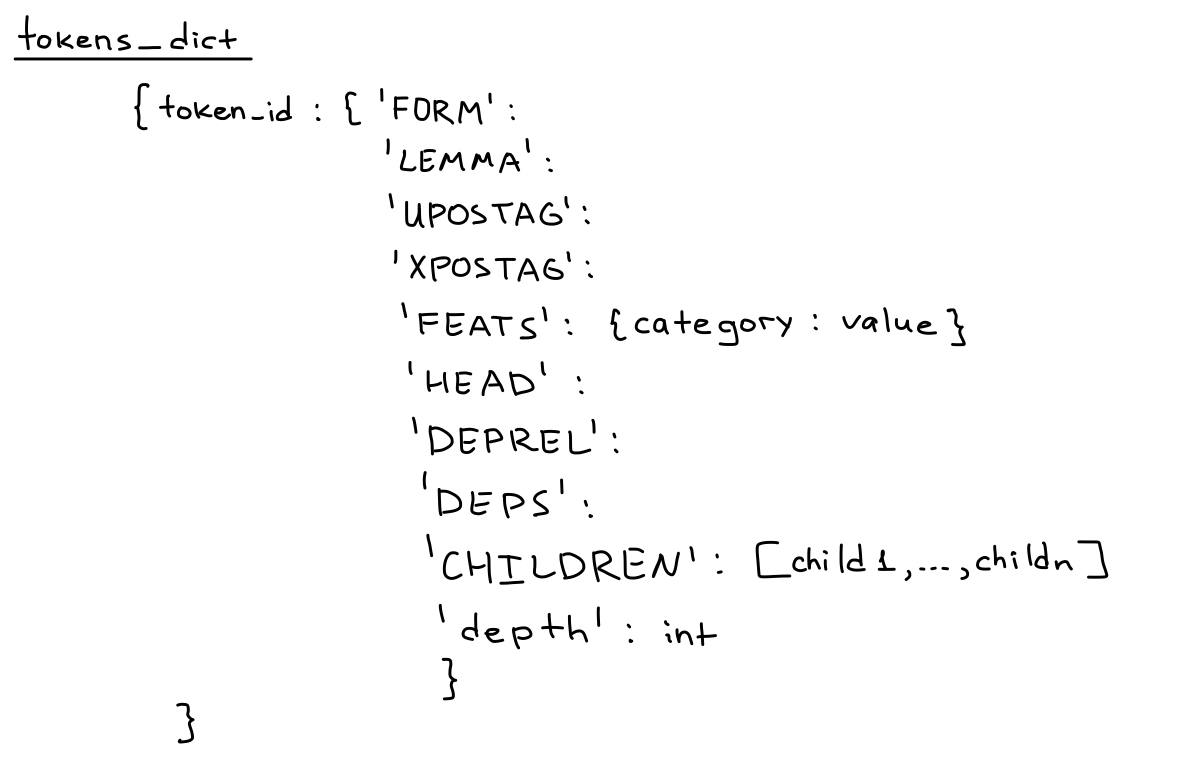

Следующие 4 функции используются при дизамбигуации. Если в каком-то предложении она не нужна, то они не применяются. *(но ради симметрии можно к каждому предложению применять)*
- find_head - Находим вершину предложения. Возвращается id вершины
- add_children - для каждого токена заполняем список ['CHILDREN'] из его непосредственных зависимых.
- get_depth - для каждого токена считаем его глубину в дереве и заполняем поле ['depth']. Для вершины предложения, это поле уже заполнено нулем. 
- tree_parse - применяет верхние 3 функции к tokens_dict *(❓ я вообще не умею обходить деревья и с рекурсией не дружу, но что-то все-таки получилось. вопрос, насколько это норм решение, мб можно как-то проще сделать все?)*


In [24]:
def find_head(tokens_dict):
    for token in tokens_dict:
        if tokens_dict[token]['HEAD'] == '0':
            return token

In [25]:
def add_children(tokens_dict):
    for token in tokens_dict:
        token_info = tokens_dict[token]
        head = token_info['HEAD']
        if head != '0' and head != '_':
            tokens_dict[head]['CHILDREN'].append(token)

In [26]:
def get_depth(tokens_dict, children):
    for token in children:
        token_info = tokens_dict[token]
        head = token_info['HEAD']
        token_info['depth'] = tokens_dict[head]['depth'] + 1
        if len(token_info['CHILDREN']) > 0:
            get_depth(tokens_dict, token_info['CHILDREN'])

In [27]:
def parse_tree(tokens_dict):
    head = find_head(tokens_dict)
    add_children(tokens_dict)
    get_depth(tokens_dict, tokens_dict[head]['CHILDREN'])

Находим токен, по которому будем классифицировать предложение по заданной категории.
Если токен с такой грамматической категорией единственный, то используем его. Если нет, то для каждого из претендентов находим глубину и выбираем того, у кого глубина меньше.

*❓ тут возникла проблема, что у некоторых токенов может не быть вершины (а тогда соответственно не посчитается глубина), но при этом есть признаки. При сочинении как в примере ниже. Поэтому для того, чтобы сравнить глубину подобного токена с другим, я приписываю ему какое-то большое число (напр. 1000). Не знаю, насколько это адекватное решение*  

*(есть еще вариант вершину определять по столбцу DEPS, но тогда при такой проблеме придется самим выбирать, какой из токенов выбрать для классификации. кажется, первый вариант проще и универсальнее)*
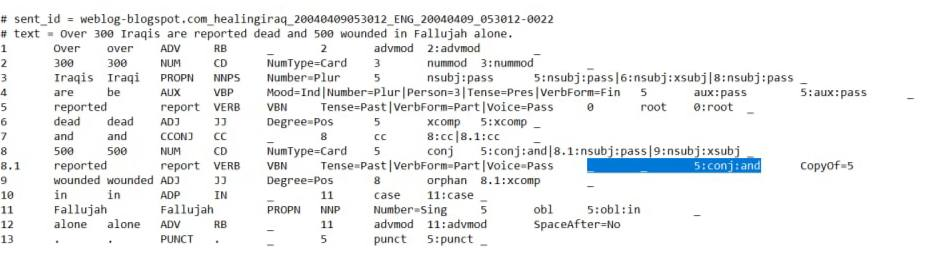

In [44]:
def token4category(category, tokens_dict):
    category_tokens = []
    for token in tokens_dict:
        if category in tokens_dict[token]['FEATS']:
            category_tokens.append(token)
    if len(category_tokens) == 0:
        return 
    elif len(category_tokens) == 1:
        return category_tokens[0]
    else:
        parse_tree(tokens_dict)
        highest = min(category_tokens, key=lambda t: tokens_dict[t].get('depth', 10000))
        return highest

In [29]:
from collections import defaultdict

Классифицирует все предложения по выбранной категории. Возвращает словарь вида {Value1: ['sentence1', ... 'sentenceN']... ValueN: ['sentence1', ... 'sentenceN']}

In [30]:
def classify(sentences, category):
    probing_data = defaultdict(list)
    for sentence in sentences:
        s_text, tokens_dict = parse_sentence(sentence)
        category_host = token4category(category, tokens_dict)
        if category_host:
            value = tokens_dict[category_host]['FEATS'][category]
            probing_data[value].append(s_text)
    return probing_data

Делим на выборки и Записываем файл для пробинга в result_path.  

Чтобы каждая часть выборки была сбалансирована по значениям, размер выборки обрезается размером списка значения с минимальным количеством примеров *(❓ вообще стоит так делать? Из-за этого предложений сильно меньше становится. Но я не знаю, как еще выборку сбалансированной сделать)*. Дальше выборки делятся в соотношении 80/10/10.

In [31]:
def writer(result_path, classified_sentences):
    with open(result_path, 'w', encoding='utf-8') as newf:
        minority_value = min(classified_sentences, key=lambda i: len(classified_sentences[i]))
        size = len(classified_sentences[minority_value])
        tr_size = int(size * 0.8)
        va_size = te_size = int((size - tr_size) / 2)
        partition = {}
        partition['tr'] = tr_size
        partition['va'] = va_size
        partition['te'] = te_size
        start = 0
        end = 0
        for part in partition:
            start = end
            end = start + partition[part]
            values = list(classified_sentences.keys())
            for value in values:
                towrite = ''
                for i in range(start, end):
                    towrite += part + '\t' + value + '\t' + classified_sentences[value][i] + '\n'
                newf.write(towrite)

In [32]:
import re

In [71]:
def main(category, conllu_path, result_path):
    with open(conllu_path, 'r', encoding='utf-8') as f:
        conllufile = f.read()
    sentences = re.findall(r'([\s\S]*?)\n\n', conllufile)
    try:
        classified_sentences = classify(sentences, category)
        writer(result_path, classified_sentences)
    except ValueError as e:
        if str(e) == 'min() arg is an empty sequence':
            print('It seems like there is no', category, 'category in this language. Try another one.')
        else:
            print(e)

In [73]:
main('Person', 'en_ewt-ud-train.conllu', 'Person.txt')